**import libraries**

In [1]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F 
import matplotlib.pyplot as plt
import copy

from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

#because we used images from the internet so we need request
import requests
from PIL import Image
from io import BytesIO



In [2]:
#The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.
#Think of a batch as a for-loop iterating over one or more samples and making predictions.
numb_batch = 64

**Getting Data**

In [3]:
#We need to transform the image into a tensor that can be used, so we do torchvision.transforms.ToTensor().
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

train_data=torchvision.datasets.MNIST("mnist_data", train=True, download=True, transform=T)
val_data=torchvision.datasets.MNIST("mnist_data", train=False, download=True, transform=T)#difference is that we will not train this it's for validation 

#We also need the dataloaders for each dataset and set the batch size to the wanted number, 64.
train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



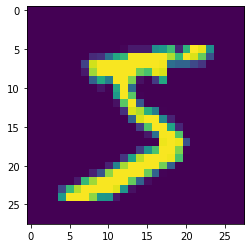

In [4]:
#show data sample 
plt.imshow(train_data[0][0][0])

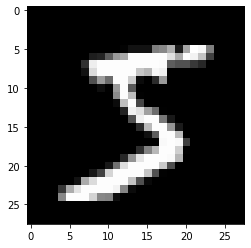

In [5]:
plt.imshow(train_data[0][0][0], cmap="gray")

**Create model**

In [6]:
#For the Mnist dataset, we will be using the LeNet 5 architecture
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

**Validate model**

In [7]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

**Training function**

In [8]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

**Gpu availability**

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

device(type='cuda', index=0)

**Training the model**

Saving Best Model with Accuracy:  95.4800033569336
Epoch: 1 Accuracy : 95.4800033569336 %
Saving Best Model with Accuracy:  97.2300033569336
Epoch: 2 Accuracy : 97.2300033569336 %
Saving Best Model with Accuracy:  97.88999938964844
Epoch: 3 Accuracy : 97.88999938964844 %
Saving Best Model with Accuracy:  98.18000030517578
Epoch: 4 Accuracy : 98.18000030517578 %
Saving Best Model with Accuracy:  98.69000244140625
Epoch: 5 Accuracy : 98.69000244140625 %
Epoch: 6 Accuracy : 98.37999725341797 %
Saving Best Model with Accuracy:  98.72000122070312
Epoch: 7 Accuracy : 98.72000122070312 %
Saving Best Model with Accuracy:  98.75
Epoch: 8 Accuracy : 98.75 %
Saving Best Model with Accuracy:  98.80000305175781
Epoch: 9 Accuracy : 98.80000305175781 %
Epoch: 10 Accuracy : 98.7300033569336 %
Epoch: 11 Accuracy : 98.79000091552734 %
Epoch: 12 Accuracy : 98.61000061035156 %
Saving Best Model with Accuracy:  98.8499984741211
Epoch: 13 Accuracy : 98.8499984741211 %
Saving Best Model with Accuracy:  98.91

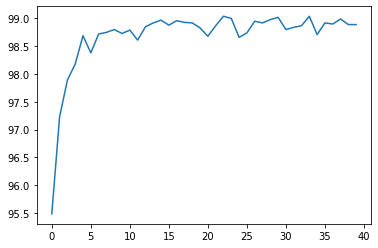

In [10]:
lenet = train(40, device=device)

**Creating the Function to test validation data**

In [11]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [12]:
y_pred, y_true = predict_dl(lenet, val_dl)

In [13]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,975,1,0,0,0,0,2,1,1,0
1,0,1134,0,0,0,0,0,0,1,0
2,3,1,1027,0,0,0,0,0,1,0
3,0,0,1,999,0,3,0,3,3,1
4,0,0,1,0,977,0,2,0,0,2
5,2,1,0,7,0,880,1,0,1,0
6,3,3,1,0,0,1,949,0,1,0
7,1,1,5,1,0,0,0,1018,1,1
8,2,0,1,1,1,1,0,1,966,1
9,1,2,0,0,11,6,1,5,4,979


**Define Inference function to get prediction for any given image**

In [52]:
def inference(path, model, device):
    #r = requests.get(path)
    #with BytesIO(r.content) as f:
  img = Image.open(path).convert(mode="L")
  img = img.resize((28, 28))
  x = (255 - np.expand_dims(np.array(img), -1))/255.
    
  with torch.no_grad():
    pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
    return F.softmax(pred, dim=-1).cpu().numpy()

**Testing images**

In [15]:
#image_1
path = "https://previews.123rf.com/images/aroas/aroas1704/aroas170400068/79321959-handwritten-sketch-black-number-8-on-white-background.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

**Showing the image**

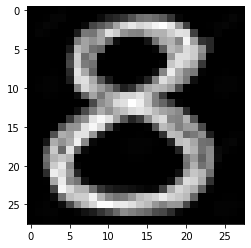

In [16]:
plt.imshow(x.squeeze(-1), cmap="gray")

**Predictions**

In [17]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 8, Prob: 99.69210624694824 %


In [18]:
#image_2
path = "https://previews.123rf.com/images/aroas/aroas1704/aroas170400040/79299050-handwritten-sketch-black-number-2-on-white-background.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

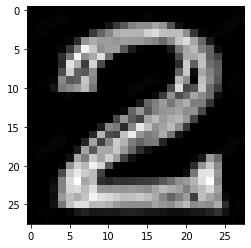

In [19]:
plt.imshow(x.squeeze(-1), cmap="gray")

In [20]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 2, Prob: 99.99624490737915 %


In [21]:
#image_3
path = "https://previews.123rf.com/images/aroas/aroas1704/aroas170400061/79321951-handwritten-sketch-black-number-5-on-white-background.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

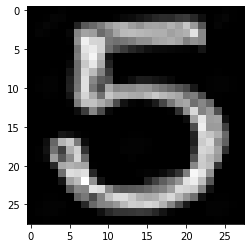

In [22]:
plt.imshow(x.squeeze(-1), cmap="gray")

In [23]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 5, Prob: 100.0 %


In [24]:
#trying 7 because it got the 5 times as 2
#image_4
path = "https://ak.picdn.net/shutterstock/videos/23708860/thumb/1.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

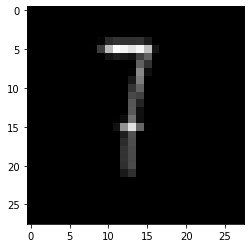

In [25]:
plt.imshow(x.squeeze(-1), cmap="gray")

In [26]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 7, Prob: 40.901705622673035 %


In [27]:
#trying another 7
path = "https://previews.123rf.com/images/aroas/aroas1704/aroas170400043/79321936-croquis-manuscrit-noir-num%C3%A9ro-7-sur-fond-blanc.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

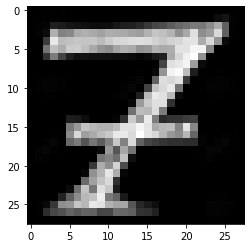

In [28]:
plt.imshow(x.squeeze(-1), cmap="gray")

In [29]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 7, Prob: 99.99998807907104 %


In [30]:
#trying 6 because it got the 6 times as 4
#image_5
path = "https://ak.picdn.net/shutterstock/videos/23708536/thumb/1.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

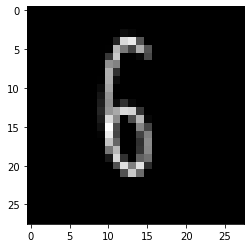

In [31]:
plt.imshow(x.squeeze(-1), cmap="gray")

In [32]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 6, Prob: 92.60783195495605 %


In [33]:
#trying another 7
path = "https://previews.123rf.com/images/aroas/aroas1704/aroas170400034/79321929-croquis-manuscrit-noir-num%C3%A9ro-6-sur-fond-blanc.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

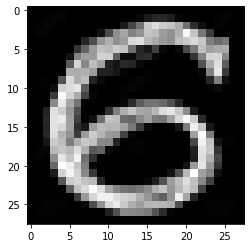

In [34]:
plt.imshow(x.squeeze(-1), cmap="gray")

In [35]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 5, Prob: 70.41106224060059 %


**Trying our data**

In [53]:
#2
path = "/content/2.PNG"
#r = requests.get(path)
#with BytesIO(r.content) as f:
img = Image.open("/content/2.PNG").convert(mode="L")
img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

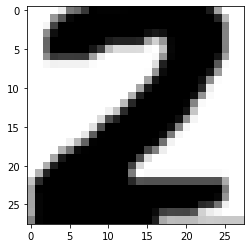

In [54]:
plt.imshow(x.squeeze(-1), cmap="gray")

In [55]:
pred = inference(path,lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 2, Prob: 99.94364380836487 %


In [59]:
#3
path = "/content/278616056_384012130236034_7798205589459402827_n.png"
#r = requests.get(path)
#with BytesIO(r.content) as f:
img = Image.open(path).convert(mode="L")
img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

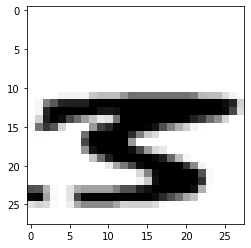

In [60]:
plt.imshow(x.squeeze(-1), cmap="gray")

In [61]:
pred = inference(path,lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 5, Prob: 88.41745853424072 %


In [62]:
#5
path = "/content/5.PNG"
#r = requests.get(path)
#with BytesIO(r.content) as f:
img = Image.open(path).convert(mode="L")
img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

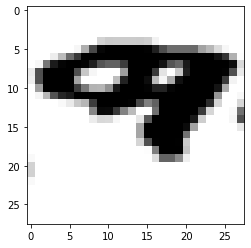

In [63]:
plt.imshow(x.squeeze(-1), cmap="gray")

In [64]:
pred = inference(path,lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 3, Prob: 97.83632755279541 %


In [65]:
#5
path = "/content/6.PNG"
#r = requests.get(path)
#with BytesIO(r.content) as f:
img = Image.open(path).convert(mode="L")
img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

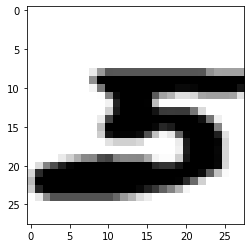

In [66]:
plt.imshow(x.squeeze(-1), cmap="gray")

In [67]:
pred = inference(path,lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 5, Prob: 99.97430443763733 %


In [68]:
#5
path = "/content/4.PNG"
#r = requests.get(path)
#with BytesIO(r.content) as f:
img = Image.open(path).convert(mode="L")
img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

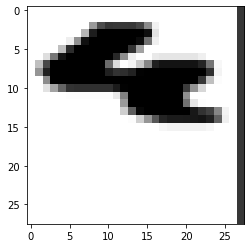

In [69]:
plt.imshow(x.squeeze(-1), cmap="gray")

In [70]:
pred = inference(path,lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 5, Prob: 96.53371572494507 %
